In [1]:
# =====================
# 1. 导入依赖
# =====================
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# =====================
# 2. 设置参数
# =====================
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
IMG_SIZE = 256
LEARNING_RATE = 1e-4
EPOCHS = 30

# 多GPU设置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_GPUS = torch.cuda.device_count()
print(f"可用GPU数量: {NUM_GPUS}")
if NUM_GPUS > 1:
    print(f"使用多GPU训练: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
    BATCH_SIZE = 64  # 双GPU时增加batch size
    NUM_WORKERS = 8  # 多GPU时增加数据加载线程
else:
    BATCH_SIZE = 32
    NUM_WORKERS = 4

print(f"Batch Size: {BATCH_SIZE}")
print(f"Num Workers: {NUM_WORKERS}")

可用GPU数量: 2
使用多GPU训练: ['Tesla T4', 'Tesla T4']
Batch Size: 64
Num Workers: 8


In [3]:
# =====================
# 3. 构建标签 DataFrame
# =====================
classes = ['Real', 'Fake']
filepaths, labels = [], []

for label_idx, cls in enumerate(classes):
    folder = os.path.join(BASE_PATH, cls)
    for img_name in os.listdir(folder):
        filepaths.append(os.path.join(folder, img_name))
        labels.append(label_idx)

labels_df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"总图片数: {len(labels_df)}")
print(labels_df.head())

总图片数: 140002
                                            filepath  label
0  /kaggle/input/deepfake-and-real-images/Dataset...      0
1  /kaggle/input/deepfake-and-real-images/Dataset...      0
2  /kaggle/input/deepfake-and-real-images/Dataset...      0
3  /kaggle/input/deepfake-and-real-images/Dataset...      0
4  /kaggle/input/deepfake-and-real-images/Dataset...      0


In [4]:
# =====================
# 4. 数据划分
# =====================
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [5]:
# =====================
# 5. 数据增强 & 预处理
# =====================
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# =====================
# 6. 自定义 Dataset
# =====================
class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label

train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# 7. 构建模型 (EfficientNet-B0)
# =====================
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = True  # 微调全部参数

model.classifier[1] = nn.Linear(in_features=1280, out_features=2)
model = model.to(DEVICE)

# 多GPU支持
if NUM_GPUS > 1:
    model = nn.DataParallel(model)
    print(f"✅ 模型已配置为多GPU训练，使用 {NUM_GPUS} 个GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 147MB/s]


✅ 模型已配置为多GPU训练，使用 2 个GPU


In [8]:
# =====================
# 8. 训练 & 验证循环 + Early Stopping
# =====================
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # 保存模型时处理多GPU情况
        if NUM_GPUS > 1:
            torch.save(model.module.state_dict(), "best_model.pth")
        else:
            torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break

Epoch 1/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [1/30] | Train Loss: 0.0874 | Val Loss: 0.0432 | Val Acc: 0.9843
✅ Best model saved.


Epoch 2/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [2/30] | Train Loss: 0.0408 | Val Loss: 0.0378 | Val Acc: 0.9863
✅ Best model saved.


Epoch 3/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [3/30] | Train Loss: 0.0304 | Val Loss: 0.0338 | Val Acc: 0.9880
✅ Best model saved.


Epoch 4/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [4/30] | Train Loss: 0.0255 | Val Loss: 0.0405 | Val Acc: 0.9873


Epoch 5/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [5/30] | Train Loss: 0.0210 | Val Loss: 0.0383 | Val Acc: 0.9881


Epoch 6/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [6/30] | Train Loss: 0.0187 | Val Loss: 0.0394 | Val Acc: 0.9873


Epoch 7/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 0.0156 | Val Loss: 0.0412 | Val Acc: 0.9886


Epoch 8/30 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [8/30] | Train Loss: 0.0146 | Val Loss: 0.0442 | Val Acc: 0.9886
⛔ Early stopping triggered.


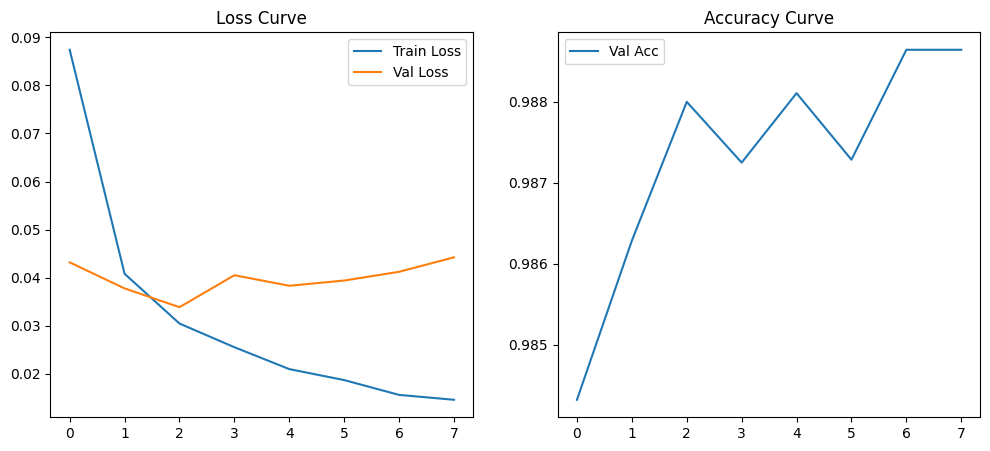

In [9]:
# =====================
# 9. 训练曲线可视化
# =====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

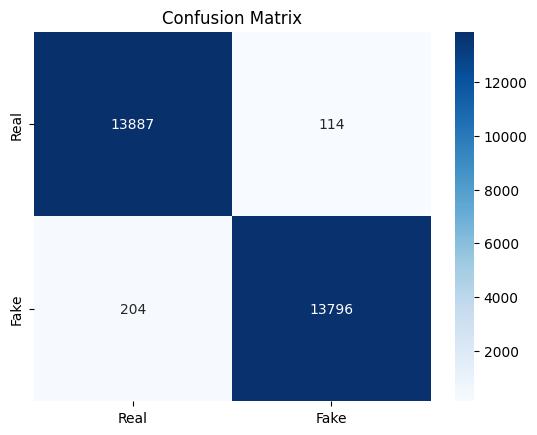

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99     14001
        Fake       0.99      0.99      0.99     14000

    accuracy                           0.99     28001
   macro avg       0.99      0.99      0.99     28001
weighted avg       0.99      0.99      0.99     28001



In [10]:
# =====================
# 10. 混淆矩阵 & 报告
# =====================
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))
